In [4]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_color_codes()

Populating the interactive namespace from numpy and matplotlib


In [1]:
import codecs
from unidecode import unidecode

In [2]:
import requests

In [519]:
wiki = 'https://en.wikipedia.org'
res = requests.get(wiki + '/wiki/Lists_of_people_by_nationality')

In [522]:
list_urls = {}
for line in res.content.split('\n'):
    if line.startswith('<li><a href="/wiki/List_of_'):
        l =  line.split('<li><a href="')[-1] \
                 .split('" title=')[0]
        country = l.split('/wiki/List_of_')[-1]
        list_urls[country] = l

In [524]:
f1 = lambda s: s.startswith('<li><a href="/wiki/')
c1 = lambda s: s.split('" title="')[-1].split('"')[0]

In [525]:
lists = {}
for country in list_urls:
    content = requests.get(wiki + list_urls[country]).text.split('\n')
    lists[country] = map(unidecode, map(c1, filter(f1, content)))

In [526]:
with open('name_list.tsv', 'w') as fh:
    for country in lists:
        for name in lists[country]:
            fh.write('{}\t{}\n'.format(name, country))

In [463]:
df = pd.read_table('name_list.tsv', header=-1)
df.columns = ['name', 'country']

In [464]:
df.shape

(68634, 2)

In [466]:
df.country.unique().shape

(214,)

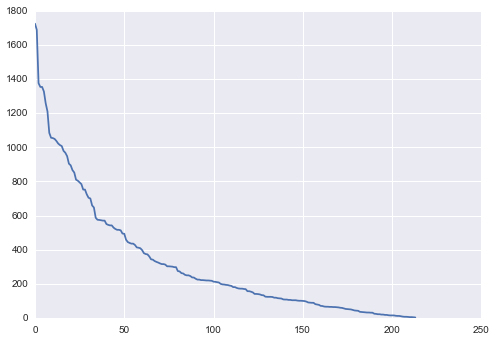

In [6]:
plt.plot(df.country.value_counts());

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split

In [327]:
name_train, name_test, country_train, country_test = train_test_split(df.name, df.country, test_size=10000)

In [408]:
name_clf = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

In [409]:
name_clf.fit(name_train, country_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 5), pre...False,
         use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [410]:
predicted = name_clf.predict(name_test)
np.mean(predicted == country_test)

0.27860000000000001

In [411]:
t5 = name_clf.predict_log_proba(name_test).argsort(axis=1)[:,-5:]
a = country_test
b = name_clf.get_params()['clf'].classes_[t5]
np.mean((a[:, None] == b).max(1))

0.4647

In [412]:
    from sklearn.grid_search import RandomizedSearchCV

In [ ]:
a = 10 ** np.linspace(-5, 0)
rscv = RandomizedSearchCV(name_clf,
    param_distributions={'clf__alpha': a},
    n_iter=10,
    n_jobs=2)

In [ ]:
rscv.fit(name_train, country_train)

In [413]:
rscv.best_params_

{'clf__alpha': 0.014563484775012445}

In [414]:
name_clf = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.014563484775012445))])

In [415]:
name_clf.fit(name_train, country_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 5), pre...     use_idf=True)), ('clf', MultinomialNB(alpha=0.014563484775, class_prior=None, fit_prior=True))])

In [416]:
predicted = name_clf.predict(name_test)
np.mean(predicted == country_test)

0.41460000000000002

In [417]:
t5 = name_clf.predict_log_proba(name_test).argsort(axis=1)[:,-5:]
a = country_test
b = name_clf.get_params()['clf'].classes_[t5]
np.mean((a[:, None] == b).max(1))

0.66959999999999997

In [418]:
def top_countries(name):
    log_proba = name_clf.predict_log_proba([name])
    t5 = log_proba.argsort(axis=1)[:,-5:]
    b = name_clf.get_params()['clf'].classes_[t5]
    for c, lp in zip(b[0], log_proba[:,t5].flatten())[::-1]:
        print '{}\t\t{}'.format(c, np.exp(lp))

In [467]:
top_countries('angela merkel')

Irish_people		0.0630450564662
Bulgarians		0.0570305684212
Vietnamese		0.0439040458422
Greeks		0.0339224373089
English_people		0.0335937870715


In [424]:
from sklearn.decomposition import TruncatedSVD

In [425]:
tf_pipeline = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer())])

In [426]:
name_features = tf_pipeline.fit_transform(name_train)

In [427]:
name_features.shape

(58634, 100000)

In [428]:
np.sqrt(100000)

316.22776601683796

In [429]:
tsvd = TruncatedSVD(n_components=400)

In [430]:
tsvd.fit(name_features)

TruncatedSVD(algorithm='randomized', n_components=400, n_iter=5,
       random_state=None, tol=0.0)

In [432]:
tsvd.explained_variance_ratio_.sum()

0.27138872714390422

In [433]:
np.linalg.norm(tsvd.components_[:, :], axis=0)

array([ 0.41199276,  0.09340333,  0.05031815, ...,  0.00577789,
        0.01585361,  0.01177398])

In [434]:
idx = np.linalg.norm(tsvd.components_[:, :], axis=0).argsort()

In [435]:
from sklearn.base import TransformerMixin 

In [468]:
class Reducer(TransformerMixin):
    def __init__(self, idx):
        self.idx = idx
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)
    
    def transform(self, X):
        return X[:, self.idx]
    
    def get_params(self, *k, **kw):
        return {'': ''}

In [469]:
name_clf = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer()),
                     ('reducer', Reducer(idx[-100:])),
                     ('clf', MultinomialNB(alpha=0.014563484775012445))])

In [471]:
name_clf.fit(name_train, country_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 5), pre...ct at 0x1137a58d0>), ('clf', MultinomialNB(alpha=0.014563484775, class_prior=None, fit_prior=True))])

In [442]:
ns = []
scores = []
for n in np.linspace(100, 100000, 10):
    name_clf = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer()),
                     ('reducer', Reducer(idx[-n:])),
                     ('clf', MultinomialNB(alpha=0.014563484775012445))])
    name_clf.fit(name_train, country_train)
    t5 = name_clf.predict_log_proba(name_test).argsort(axis=1)[:,-5:]
    a = country_test
    b = name_clf.get_params()['clf'].classes_[t5]
    s = np.mean((a[:, None] == b).max(1))
    scores.append(s)

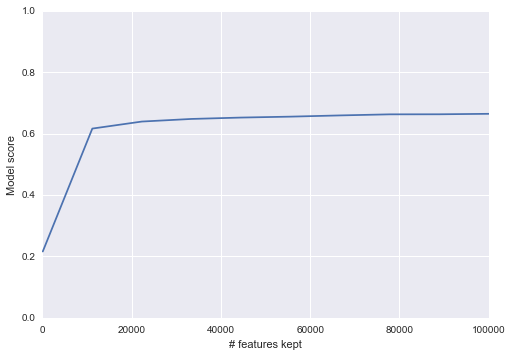

In [473]:
plt.plot(np.linspace(100, 100000, 10), scores);
plt.ylim(0, 1);
sns.axlabel('# features kept', 'Model score')

In [446]:
np.linspace(100, 100000, 10)

array([    100.,   11200.,   22300.,   33400.,   44500.,   55600.,
         66700.,   77800.,   88900.,  100000.])

In [453]:
name_clf = Pipeline([('vect', CountVectorizer(analyzer='char',
                                              ngram_range=(1,5),
                                              max_features=100000)),
                     ('tfidf', TfidfTransformer()),
                     ('reducer', Reducer(idx[-15000:])),
                     ('clf', MultinomialNB(alpha=0.014563484775012445))])

In [454]:
name_clf.fit(name_train, country_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 5), pre...ct at 0x16230db50>), ('clf', MultinomialNB(alpha=0.014563484775, class_prior=None, fit_prior=True))])

In [455]:
t5 = name_clf.predict_log_proba(name_test).argsort(axis=1)[:,-5:]
a = country_test
b = name_clf.get_params()['clf'].classes_[t5]
s = np.mean((a[:, None] == b).max(1))
s

0.62849999999999995

In [458]:
full_name_features = tf_pipeline.fit_transform(df.name)

In [459]:
tsvd.fit(full_name_features)

TruncatedSVD(algorithm='randomized', n_components=400, n_iter=5,
       random_state=None, tol=0.0)

In [460]:
tsvd.explained_variance_ratio_.sum()

0.27108212772717488

In [461]:
idx = np.linalg.norm(tsvd.components_[:, :], axis=0).argsort()

In [462]:
pd.Series(idx[-15000:]).to_csv('idx.csv', index=False)